In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [447]:
df = pd.read_csv('HA_analysis/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [448]:
df = df.sample(frac=1).reset_index(drop=True)

In [450]:
df.to_csv('ha_data.csv')


In [510]:
# Hyper-parameters 
input_size = 13   
num_classes = 2
num_epochs = 10
batch_size = 1
learning_rate = 0.01

In [511]:
hidden_size = 500

In [512]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [523]:
class GetTrainDataset(Dataset):
    

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        
        self.transform = transform

    def __len__(self):
        
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data_x = self.landmarks_frame
        data_x = data_x.to_numpy()
        #labels = np.transpose(data_x[:,13]);
        labels = np.transpose(data_x[0:270,14]);
    
        labels = labels.astype('float')
        
        
        #features=data_x[:,0:13];
        features=data_x[0:270,1:14];
        features = features.astype('float')
        
        
        
        sample = {'features': features, 'labels': labels}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [524]:
class GetTestDataset(Dataset):
    

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        
        self.transform = transform

    def __len__(self):
        
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data_x = self.landmarks_frame
        data_x = data_x.to_numpy()
        #labels = np.transpose(data_x[:,13]);
        labels = np.transpose(data_x[270:304,14]);
    
        labels = labels.astype('float')
        
        
        #features=data_x[:,0:13];
        features=data_x[270:304,1:14];
        features = features.astype('float')
        
        
        
        sample = {'features': features, 'labels': labels}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [525]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        features, labels = sample['features'], sample['labels']
        #print("l")
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        return {'features': torch.from_numpy(features),
                'labels': torch.from_numpy(labels)}

In [526]:
transformed_dataset = GetTrainDataset(csv_file='ha_data.csv',
                                           
                                           transform=transforms.Compose([
                                              
                                               ToTensor()
                                           ]))
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)  

In [527]:
test_dataset = GetTestDataset(csv_file='ha_data.csv',
                                           
                                           transform=transforms.Compose([
                                              
                                               ToTensor()
                                           ]))

test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [528]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [529]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [530]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


Epoch [1/10], Step [100/303], Loss: 0.4433
Epoch [1/10], Step [200/303], Loss: 0.3593
Epoch [1/10], Step [300/303], Loss: 0.3288
Epoch [2/10], Step [100/303], Loss: 0.3063
Epoch [2/10], Step [200/303], Loss: 0.2824
Epoch [2/10], Step [300/303], Loss: 0.2522
Epoch [3/10], Step [100/303], Loss: 0.2635
Epoch [3/10], Step [200/303], Loss: 0.1844
Epoch [3/10], Step [300/303], Loss: 0.1597
Epoch [4/10], Step [100/303], Loss: 0.1650
Epoch [4/10], Step [200/303], Loss: 0.1140
Epoch [4/10], Step [300/303], Loss: 0.1055
Epoch [5/10], Step [100/303], Loss: 0.0815
Epoch [5/10], Step [200/303], Loss: 0.0658
Epoch [5/10], Step [300/303], Loss: 0.0587
Epoch [6/10], Step [100/303], Loss: 0.2184
Epoch [6/10], Step [200/303], Loss: 0.1443
Epoch [6/10], Step [300/303], Loss: 0.1144
Epoch [7/10], Step [100/303], Loss: 0.0920
Epoch [7/10], Step [200/303], Loss: 0.0775
Epoch [7/10], Step [300/303], Loss: 0.0644
Epoch [8/10], Step [100/303], Loss: 0.3231
Epoch [8/10], Step [200/303], Loss: 0.0704
Epoch [8/10

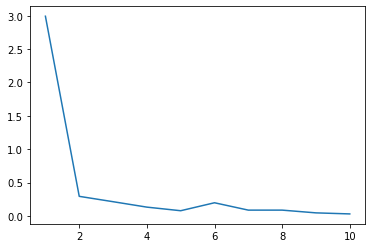

In [531]:
total_step = len(dataloader)
curr_lr = learning_rate
loss_vals=  []
for epoch in range(num_epochs):
    epoch_loss= []
    for i_batch, sample_batched in enumerate(dataloader):
        # Reshape images to (batch_size, input_size)
        #images = images.reshape(-1, input_size)
        features=sample_batched['features'];
        labels=sample_batched['labels'];
        # Forward pass
        
        features = features.reshape(-1, input_size)
        features = features.type(torch.FloatTensor)
        
        outputs = model(features)
        #print(outputs)
        #print(labels.shape)
        labels= torch.reshape(labels, (-1,))
        labels = labels.to(dtype=torch.float32) 
        labels=labels.type(torch.LongTensor)
        
        
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        epoch_loss.append(loss.item())
        
        optimizer.step()
        #print("a")
        if (i_batch+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i_batch+1, total_step, loss.item()))
    
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
        
my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)


In [533]:
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, sample_batched in enumerate(test_loader):
        features=sample_batched['features'];
        labels=sample_batched['labels'];
        features = features.reshape(-1, input_size)
        features = features.type(torch.FloatTensor)
        
        labels= torch.reshape(labels, (-1,))
        labels = labels.to(dtype=torch.float32) 
        labels=labels.type(torch.LongTensor)
        
        
        
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Test set accuracy: {} %'.format(100 * correct / total))

Test set accuracy: 87 %
